In [1]:
import numpy as np
import math
import statistics as stat
import random
import pandas as pd

from scipy.optimize import isotonic_regression
from sklearn.isotonic import IsotonicRegression
from scipy.interpolate import interp1d

from matchings import cross_bin_matching, same_bin_matching, immediate_neighbor_matching, max_weight_matching
from scipy.stats import norm
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches


lblue = (40/255,103/255,178/255)
sgreen = (46/255,139/255,87/255)
cred = (0.69411765, 0.01568627, 0.05490196)

In [2]:
def SCINT_test(X, Y, M, nperm=1500):
    Del_X = np.array([X[i]-X[j] for (i,j) in M])
    Del_Y = np.array([Y[i]-Y[j] for (i,j) in M])

    
    D_S = np.einsum('ij, j, j -> i', 
                    (np.random.rand(nperm, len(M)) < .5), 
                    Del_X, 
                    Del_Y)
    
    return (1+np.sum(D_S <= 0))/(1+nperm)

def marg_indep_test(X, Y, nperm=1500):
    T = abs(np.dot(X,Y))
    T_S = []
    for t in range(nperm):
        X_S = X[np.random.permutation(len(X))]    
        T_S.append(abs(np.dot(X_S,Y)))
    return (1+np.sum(T_S >= T))/(1+nperm)
    

## Data setup

In [3]:
data = pd.read_csv('diabetes.csv')
data = data.dropna()
print(data.shape)
print(list(data.columns))
data.head()

(768, 9)
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


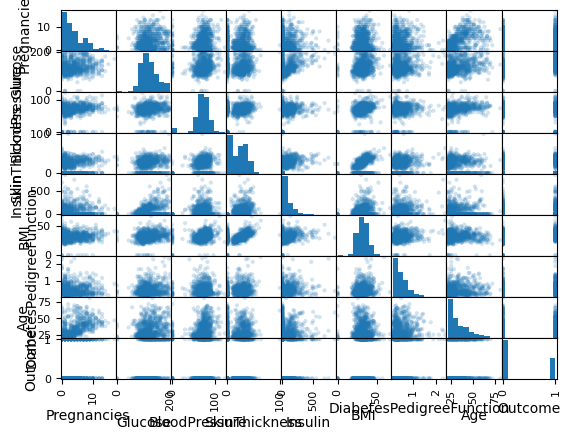

In [4]:
pd.plotting.scatter_matrix(data, alpha=0.2);

## Checking Stoch Monotonicity

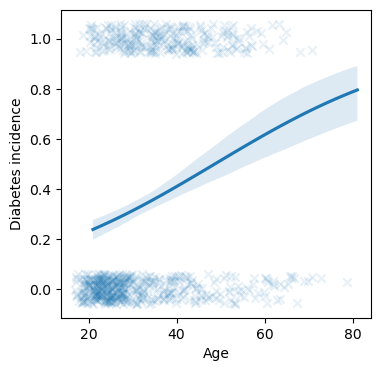

In [5]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize =(4,4))
b = sns.regplot(x=data["Age"],y=data["Outcome"], logistic=True, x_jitter = 4, y_jitter = 0.06,
            marker = 'x', scatter_kws = {'alpha':0.1})
b.set_xlabel("Age", fontsize=10)
b.set_ylabel("Diabetes incidence", fontsize=10)
fig.savefig('figures/relation_with_age.pdf')

## checking relation with other variables

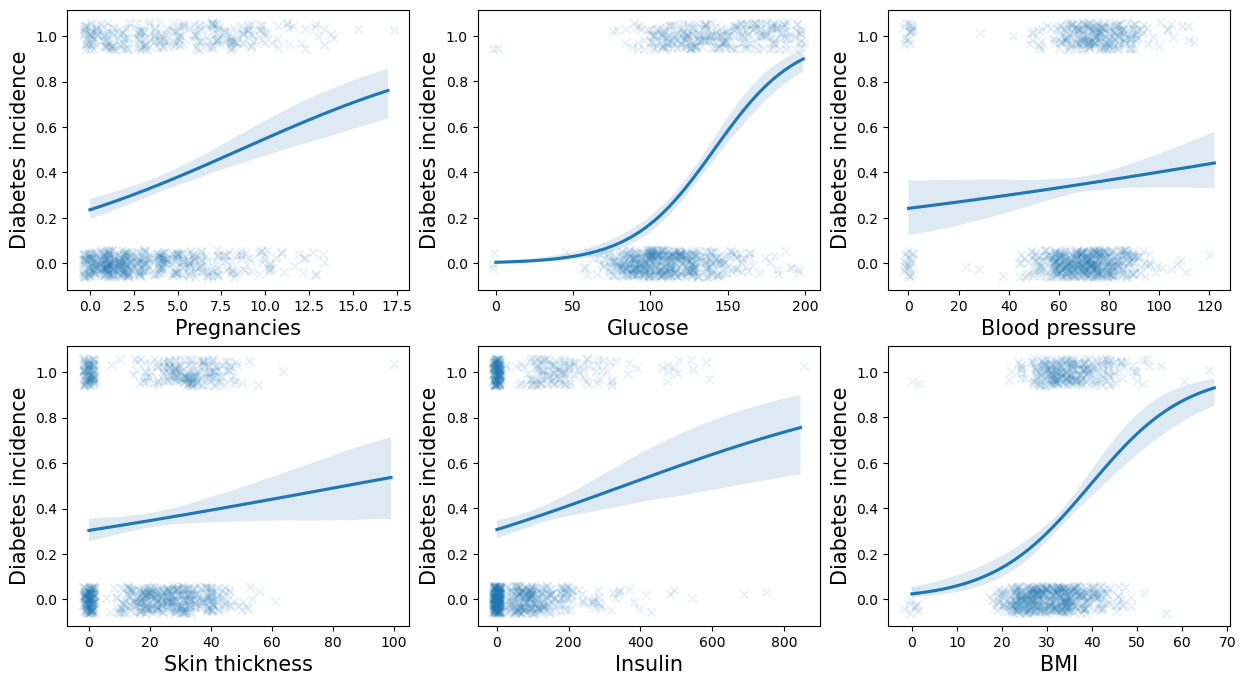

In [6]:
fig, ax = plt.subplots(2,3, figsize =(15,8))
b = sns.regplot(x=data["Pregnancies"],y=data["Outcome"], logistic=True, x_jitter = 0.4, y_jitter = 0.06, 
            marker = 'x', scatter_kws = {'alpha':0.1}, ax=ax[0,0]);
b.set_xlabel("Pregnancies", fontsize=15)
b.set_ylabel("Diabetes incidence", fontsize=15)
b = sns.regplot(x=data["Glucose"],y=data["Outcome"], logistic=True, x_jitter = 2, y_jitter = 0.06, 
            marker = 'x', scatter_kws = {'alpha':0.1}, ax=ax[0,1]);
b.set_xlabel("Glucose", fontsize=15)
b.set_ylabel("Diabetes incidence", fontsize=15)
b = sns.regplot(x=data["BloodPressure"],y=data["Outcome"], logistic=True, x_jitter = 2, y_jitter = 0.06, 
            marker = 'x', scatter_kws = {'alpha':0.1}, ax=ax[0,2]);
b.set_xlabel("Blood pressure", fontsize=15)
b.set_ylabel("Diabetes incidence", fontsize=15)
b = sns.regplot(x=data["SkinThickness"],y=data["Outcome"], logistic=True, x_jitter = 2, y_jitter = 0.06, 
            marker = 'x', scatter_kws = {'alpha':0.1}, ax=ax[1,0]);
b.set_xlabel("Skin thickness", fontsize=15)
b.set_ylabel("Diabetes incidence", fontsize=15)
b = sns.regplot(x=data["Insulin"],y=data["Outcome"], logistic=True, x_jitter = 10, y_jitter = 0.06, 
            marker = 'x', scatter_kws = {'alpha':0.1}, ax=ax[1,1]);
b.set_xlabel("Insulin", fontsize=15)
b.set_ylabel("Diabetes incidence", fontsize=15)
b = sns.regplot(x=data["BMI"],y=data["Outcome"], logistic=True, x_jitter = 2, y_jitter = 0.06, 
            marker = 'x', scatter_kws = {'alpha':0.1}, ax=ax[1,2]);
b.set_xlabel("BMI", fontsize=15)
b.set_ylabel("Diabetes incidence", fontsize=15)
fig.savefig('figures/diabetes_risk_factors.pdf')

## Run Tests

In [7]:
# ## neighbor matching
# Z = np.array(test_data["Age"])
# X = np.array(test_data["Outcome"])
# result = pd.DataFrame(columns = ['Y', 'Marginal pvalue', 'Conditional pvalue', 'Control pvalue', 'length'])

# for i in range(6):
#     Y = np.array(test_data.iloc[:,i])
#     M_nbhd = immediate_neighbor_matching(Y, Z)

#     # fake data generation
#     o = np.argsort(train_data["Age"])
#     prob = isotonic_regression(train_data.Outcome[Itr[o]]).x
#     f = interp1d(train_data.Age[Itr[o]], prob, kind='next', assume_sorted=True, fill_value='extrapolate')
#     mu_hat = f(Z)
#     X_fake = (np.random.rand(nte) <= mu_hat)*1
    
#     result = result._append({'Y' : list(data.columns)[i], 
#                     'Marginal pvalue' : marg_indep_test(np.array(X),np.array(Y)), 
#                     'Conditional pvalue' : SCINT_test(X ,Y, M_nbhd), 
#                     'Control pvalue' : SCINT_test(X_fake ,Y, M_nbhd), 
#                     'length' : len(M_nbhd)}, ignore_index = True)
# result = pd.DataFrame(result)
# print(result)

In [12]:
K = 50; nbootstrap=3000

result_mean = result_se = pd.DataFrame()
#result_mean = pd.DataFrame(columns = ['Y', 'Marg_pvalue', 'Cond_pvalue_nghbr', 'Cond_pvalue_cbin', 'Ctrl_pvalue_nghbr', 'Ctrl_pvalue_cbin'])

marg_pval = np.zeros((nbootstrap,6))
cond_pval_nghbr = np.zeros((nbootstrap,6))
cond_pval_cbin = np.zeros((nbootstrap,6))
contr_pval_nghbr = np.zeros((nbootstrap,6))
contr_pval_cbin = np.zeros((nbootstrap,6))

for k in range(nbootstrap):
    shuffled_data = data.sample(frac=0.5, replace=False)
    Itr, Ite = np.array_split(np.random.permutation(data.shape[0]), 2)
    ntr, nte = len(Itr), len(Ite)
    train_data = data.iloc[Itr]
    test_data = data.iloc[Ite]

    o = np.argsort(train_data["Age"])
    prob = isotonic_regression(train_data.Outcome[Itr[o]]).x
    f = interp1d(train_data.Age[Itr[o]], prob, kind='next', assume_sorted=True, fill_value='extrapolate')

    #shuffled_data = test_data.sample(n=nte, replace=True)
    Z = np.array(test_data["Age"])
    X = np.array(test_data["Outcome"])

    # fake data 
    mu_hat = f(Z)
    X_fake = (np.random.rand(nte) <= mu_hat)*1
    
    for i in range(6):
        Y = np.array(test_data.iloc[:,i])
        
        ## marginal test
        marg_pval[k,i] = marg_indep_test(np.array(X),np.array(Y))
        
        ## conditional test
        M_nbhd = immediate_neighbor_matching(Y, Z)
        cond_pval_nghbr[k,i] = SCINT_test(X ,Y, M_nbhd)
        M_cb = cross_bin_matching(Y,Z,K)
        cond_pval_cbin[k,i] = SCINT_test(X ,Y, M_cb)

        ## control test
        contr_pval_nghbr[k,i] = SCINT_test(X_fake ,Y, M_nbhd)
        contr_pval_cbin[k,i] = SCINT_test(X_fake ,Y, M_cb)

result_mean = result_mean.assign(Y = list(data.columns)[0:6])
result_mean = result_mean.assign(Marg_pvalue = np.mean(marg_pval, axis=0))
result_mean = result_mean.assign(Cond_pvalue_nghbr = np.mean(cond_pval_nghbr, axis=0))
result_mean = result_mean.assign(Cond_pvalue_cbin = np.mean(cond_pval_cbin, axis=0))
result_mean = result_mean.assign(Ctrl_pvalue_nghbr = np.mean(contr_pval_nghbr, axis=0))
result_mean = result_mean.assign(Ctrl_pvalue_cbin = np.mean(contr_pval_cbin, axis=0))
result_mean.iloc[:,1:6] = round(result_mean.iloc[:,1:6],3)
print(result_mean)

result_se = result_se.assign(Y = list(data.columns)[0:6])
result_se = result_se.assign(Marg_pvalue = np.std(marg_pval, axis=0)/np.sqrt(nbootstrap))
result_se = result_se.assign(Cond_pvalue_nghbr = np.std(cond_pval_nghbr, axis=0)/np.sqrt(nbootstrap))
result_se = result_se.assign(Cond_pvalue_cbin = np.std(cond_pval_cbin, axis=0)/np.sqrt(nbootstrap))
result_se = result_se.assign(Ctrl_pvalue_nghbr = np.std(contr_pval_nghbr, axis=0)/np.sqrt(nbootstrap))
result_se = result_se.assign(Ctrl_pvalue_cbin = np.std(contr_pval_cbin, axis=0)/np.sqrt(nbootstrap))
result_se.iloc[:,1:6] = round(result_se.iloc[:,1:6],3)
print(result_se)

               Y  Marg_pvalue  Cond_pvalue_nghbr  Cond_pvalue_cbin  \
0    Pregnancies        0.001              0.433             0.424   
1        Glucose        0.001              0.002             0.001   
2  BloodPressure        0.155              0.496             0.499   
3  SkinThickness        0.117              0.243             0.123   
4        Insulin        0.023              0.159             0.224   
5            BMI        0.001              0.033             0.001   

   Ctrl_pvalue_nghbr  Ctrl_pvalue_cbin  
0              0.511             0.544  
1              0.499             0.550  
2              0.501             0.555  
3              0.506             0.558  
4              0.497             0.545  
5              0.499             0.555  
               Y  Marg_pvalue  Cond_pvalue_nghbr  Cond_pvalue_cbin  \
0    Pregnancies        0.000              0.005             0.004   
1        Glucose        0.000              0.000             0.000   
2  BloodPres

In [42]:
np.sqrt(225)

15.0

(array([1536.,  508.,  292.,  212.,  137.,  107.,   87.,   53.,   45.,
          23.]),
 array([6.66222518e-04, 1.00333111e-01, 2.00000000e-01, 2.99666889e-01,
        3.99333777e-01, 4.99000666e-01, 5.98667555e-01, 6.98334444e-01,
        7.98001332e-01, 8.97668221e-01, 9.97335110e-01]),
 <BarContainer object of 10 artists>)

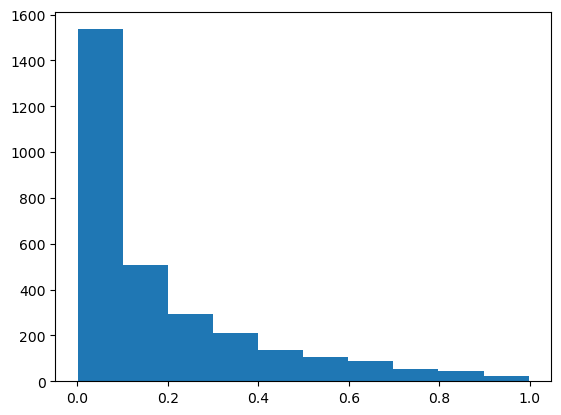

In [9]:
plt.hist(cond_pval_nghbr[:,4])
#np.std(marg_pval[:,4])

In [10]:
# ## cross-bin matching
# K = 150
# Z = np.array(test_data["Age"])
# X = np.array(test_data["Outcome"])
# result = pd.DataFrame(columns = ['Y', 'Marginal pvalue', 'Conditional pvalue', 'Control pvalue', 'length'])

# for i in range(6):
#     Y = np.array(test_data.iloc[:,i])
#     M_cb = cross_bin_matching(Y,Z,K)

#     # fake data generation
#     o = np.argsort(train_data["Age"])
#     prob = isotonic_regression(train_data.Outcome[Itr[o]]).x
#     f = interp1d(train_data.Age[Itr[o]], prob, kind='next', assume_sorted=True, fill_value='extrapolate')
#     mu_hat = f(Z)
#     X_fake = (np.random.rand(nte) <= mu_hat)*1
    
#     result = result._append({'Y' : list(data.columns)[i], 
#                     'Marginal pvalue' : marg_indep_test(np.array(X),np.array(Y)), 
#                     'Conditional pvalue' : SCINT_test(X ,Y, M_cb), 
#                     'Control pvalue' : SCINT_test(X_fake ,Y, M_cb), 
#                     'length' : len(M_cb)}, ignore_index = True)
# result = pd.DataFrame(result)
# print(result)